## The Central Question:  How to generate indicators for momentum?


It is undeniable that the stock market exhibits momentum, regardless of what economists claim about efficient markets. Why this force exists at all is not of present interest. Rather, I focus on a practical task: detecting momentum in the markets, and detecting it quickly. Doing so will enable trading strategies that take advantage of this market quirk.

Various tools have been developed to measure momentum in stock markets.  There are plenty of resources available detailing all sorts of indicators. In this notebook, I focus on the Hurst exponent. In the following cells, I touch upon how the Hurst exponent is used as a momentum indicator before turning to its estimation. Many different estimation algorithms exist, however, in the course of this notebook it will become clear that there are many subtleties and difficulties involved.

### The Hurst Exponent:

The Hurst exponent $H$ is a tool for quantifying how the autocorrelation of a time series decays as the number of lags considered increases.  
The value lies in $(0,1)$, indicating one of three behaviors:


- **$0.5 < H < 1$**: Long-term **positive autocorrelation** (trending behavior).  
  Autocorrelations decay slowly (power law, slower than exponential).  
  High values tend to be followed by high values.

- **$0 < H < 0.5$**: Long-term **negative autocorrelation** (mean-reverting).  
  Values tend to alternate high/low, with persistant switching (power-law decay).

- **$H = 0.5$**: **Short memory**.  
  Autocorrelations decay exponentially fast to zero (random walk–like).

Before jumping into technical details, it is worthwhile elucidating why this notebook even exists. Surely we should be able to simply pull a well-crafted code package that estimates the Hurst exponent, and use that in our trading strategy, right? Let's see...

To put this claim to the test, I implement a basic strategy using the Hurst exponent as follows.  First, four years of daily tick QQQ data are downloaded from `yfinance`.  Then, functions for estimating the Hurst exponent using detrended fluctuation analysis (conveniently contained within the `nolds` module) on rolling windows are defined.

The strategy I decide to implement should in theory be an improved version of the simple moving average crossover strategy we discussed on our last call.  You mentioned that this strategy fails during mean-reverting market regimes.  The issue is that buy/sell signals are generated from the up-and-down movements of the stock (on a delay relative to price action) rather than any true excursions, so we ultimately end up buying high and selling low.

Since the primary issue with this strategy is not in its conception, but in its contingency upon the market regime, I figured that if this strategy was only executed during periods of high momentum, then it should prove profitable.  That is the essence of the strategy below.  It is a SMA crossover strategy wherein positions are only opened if there is momentum (i.e. $H>0.5$).

[*********************100%***********************]  1 of 1 completed


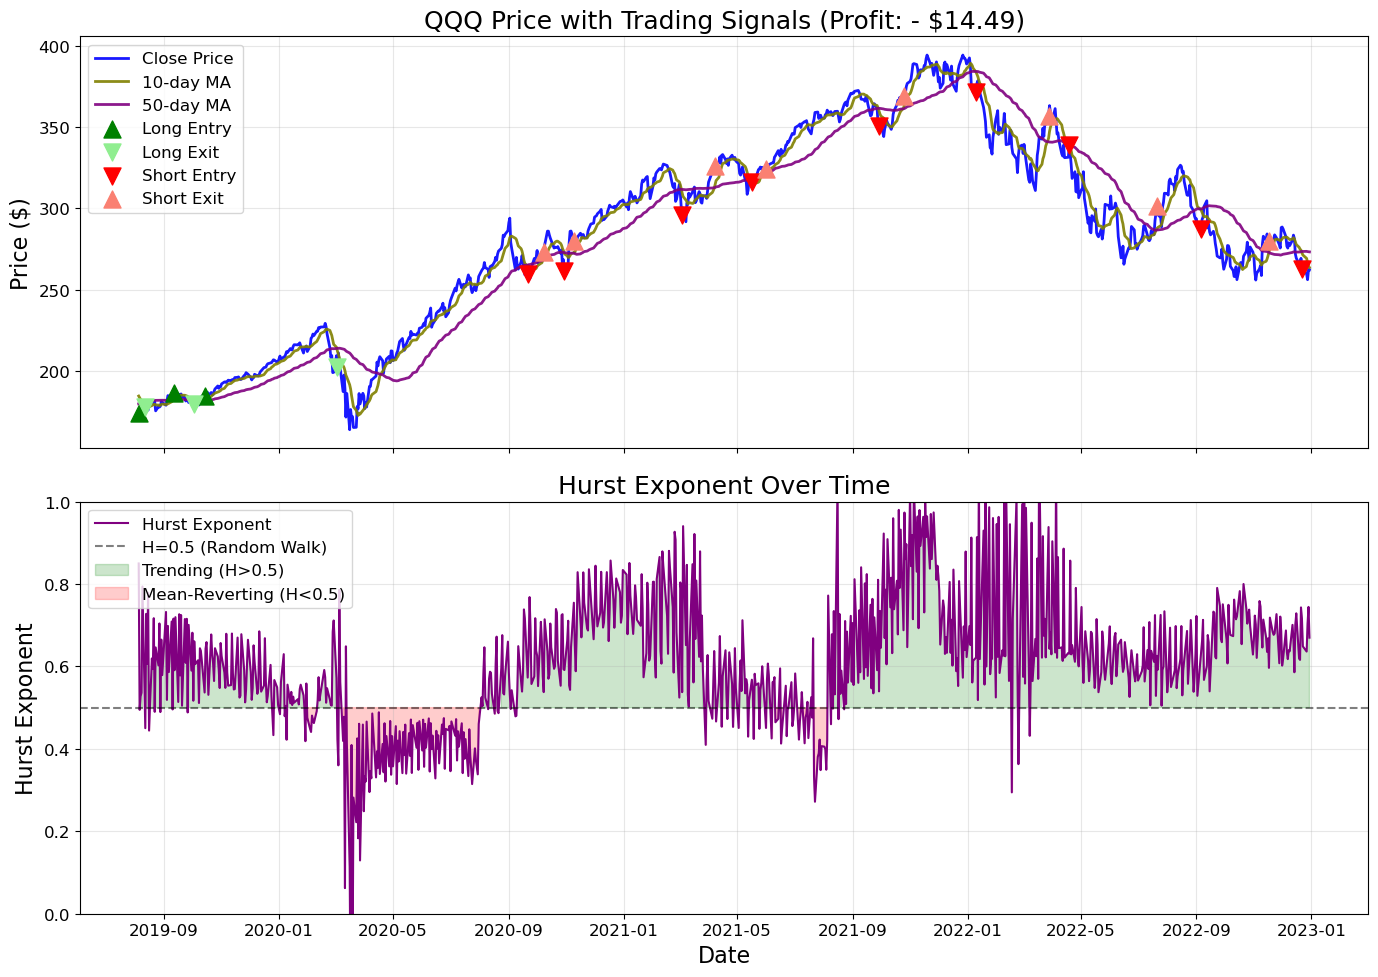

In [1]:
# necessary imports
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nolds
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

# stock data download
start = "2019-01-01"
end = "2023-01-01"
ticker = "QQQ"
qqq = yf.download(tickers=ticker, start=start, end=end, auto_adjust=True)
qqq.columns = qqq.columns.droplevel('Ticker')
qqq['Returns'] = np.log(qqq['Close']).diff()
qqq['rolling10'] = qqq['Close'].rolling(10).mean()
qqq['rolling50'] = qqq['Close'].rolling(50).mean()
qqq = qqq[['Close', 'rolling10', 'rolling50']]
qqq['10over50'] = (qqq['rolling10'] > qqq['rolling50']).astype(int)
qqq.dropna(inplace=True)

# estimating the Hurst exponent (using detrended fluctuation analysis)
def hurst(timeseries):
    if len(timeseries) < 10:
        return np.nan
    return nolds.dfa(np.diff(timeseries))

# helper method to calculate the Hurst exponent on a rolling window
def calculate_rolling_hurst_pandas(df, price_column='Close', window=100):
    df_result = df.copy()
    df_result['hurst'] = df[price_column].rolling(window=window).apply(lambda x: hurst(x.values), raw=False)
    return df_result

# estimate the Hurst exponent on our data set
qqq = calculate_rolling_hurst_pandas(qqq, price_column='Close', window=100)
qqq = qqq.dropna()

# initialization of variables and containers for generating plots
position = "flat"  
ten_over_50 = 0
price = None
profit = 0
long_entries = []
long_exits = []
short_entries = []
short_exits = []

# simple Hurst-informed SMA crossover backtest
for idx, date in enumerate(qqq.index):
    if qqq['10over50'][date] != ten_over_50: 
        if position == "short":
            profit += price - qqq['Close'][date]
            short_exits.append((date, qqq['Close'][date]))
            position = "flat"
        elif position == "long":
            profit += qqq['Close'][date] - price
            long_exits.append((date, qqq['Close'][date]))
            position = "flat"
        elif qqq['hurst'][date] > 0.5:
            if qqq['10over50'][date] == 1:  # crossed up 
                price = qqq['Close'][date]
                position = "long"
                long_entries.append((date, price))
            else:
                price = qqq['Close'][date]
                position = "short"
                short_entries.append((date, price))
        ten_over_50 = (ten_over_50 + 1) % 2

# The remainder of the code is for generating pretty plots
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot 1 price curves
ax1.plot(qqq.index, qqq['Close'], label='Close Price', linewidth=2, alpha=0.9, color='blue')
ax1.plot(qqq.index, qqq['rolling10'], label='10-day MA', linewidth=2, alpha=0.9, color='olive')
ax1.plot(qqq.index, qqq['rolling50'], label='50-day MA', linewidth=2, alpha=0.9, color='purple')

# Mark long positions
if long_entries:
    dates_e, prices_e = zip(*long_entries)
    ax1.scatter(dates_e, prices_e, color='green', marker='^', s=150, label='Long Entry', zorder=5)
if long_exits:
    dates_x, prices_x = zip(*long_exits)
    ax1.scatter(dates_x, prices_x, color='lightgreen', marker='v', s=150, label='Long Exit', zorder=5)

# Mark short positions
if short_entries:
    dates_e, prices_e = zip(*short_entries)
    ax1.scatter(dates_e, prices_e, color='red', marker='v', s=150, label='Short Entry', zorder=5)
if short_exits:
    dates_x, prices_x = zip(*short_exits)
    ax1.scatter(dates_x, prices_x, color='salmon', marker='^', s=150, label='Short Exit', zorder=5)

ax1.set_ylabel('Price ($)', fontsize=16)
ax1.set_title(
    f"{ticker} Price with Trading Signals (Profit: {'- ' if profit < 0 else ''}${abs(profit):.2f})",
    fontsize=18
)
ax1.legend(loc='upper left', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='both', labelsize=12)

# plot 2 Hurst evolution
ax2.plot(qqq.index, qqq['hurst'], label='Hurst Exponent', color='purple', linewidth=1.5)
ax2.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, linewidth=1.5, label='H=0.5 (Random Walk)')
ax2.fill_between(qqq.index, 0.5, qqq['hurst'], where=(qqq['hurst'] > 0.5), 
                  color='green', alpha=0.2, label='Trending (H>0.5)')
ax2.fill_between(qqq.index, qqq['hurst'], 0.5, where=(qqq['hurst'] < 0.5), 
                  color='red', alpha=0.2, label='Mean-Reverting (H<0.5)')

ax2.set_xlabel('Date', fontsize=16)
ax2.set_ylabel('Hurst Exponent', fontsize=16)
ax2.set_title('Hurst Exponent Over Time', fontsize=18)
ax2.legend(loc='upper left', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='both', labelsize=12)
ax2.set_ylim(0, 1)


plt.tight_layout()
plt.show()

What happened?!  The strategy proved to be worse than unprofitable.  Surely there are better implementations of this momentum-informed crossover strat, but optimizing this approach is not my goal here.  Instead, it is to learn from the failures of this simple implementation. Most glaringly, there are many months in 2020 for which the estimated Hurst exponent was negative.  Looking at the price curve, it is clear there was a long and steady trend up and to the right, which was completely missed by this momentum indicator.  

Another issue with the present estimator is the wild fluctuations exhibited.  For the estimated value to jump back and forth nearly $70\%$ of its range over the course of days intimates potential disaster.  

For these reasons and more, I wanted to analyze the behaviors of the different algorithms available, and understand the pros and cons of the various approaches.  In the work that follows, I investigate two common algorithms.


### Algorithm One (Variance of Differences): 

The Hurst exponent is essentially equivalent to the fractal dimension of a system. Therefore, in calculating what $H$ should be, it is natural to assume the process $X$ is self-similar, ie.:
$$
X(at) \stackrel{d}{=} a^H X(t), \quad a > 0
$$

Next increments are considered, as self-similar processes exhibit stationary increments ($\Delta_\tau X$ depends only on $\tau$, not on $t$).
$$
\Delta_\tau X = X(t+\tau) - X(t).
$$

Applying the scaling law to increments and then taking the variance yields:
$$
\operatorname{Var}[X(t+\tau) - X(t)] = \tau^{2H}\, \operatorname{Var}[X(1) - X(0)].
$$

Thus the variance scales like $\tau^{2H}$. Therefore, $H$ can be solved for by regressing in $\log$ space:

$$
\log \operatorname{Var}[\Delta_\tau X] = \log C + 2H \log \tau.
$$

### Code for Variance of Differences:

In [2]:
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import matplotlib.pyplot as plt
import numpy as np

def var_of_diff_hurst(ts,n):
    """
    Estimate the Hurst Exponent using the Variance of Differences method
    
    Parameters
    ----------
    ts : array-like  //  Time series for which the Hurst Exponent will be calculated
    n : int  //  Number of lags to consider 
    
    Returns
    -------
    H: float  // Estimated Hurst exponent
    """
    # Create the range of lag values
    lags = range(2, n)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    H = poly[0]*2.0
    # Return the Hurst exponent from the polyfit output
    return H

Many sources leave the number of lags considered fixed at $100$ or $200$. This seems arbitrary, and worth investigating as a hyperparameter. 

### Variance of Differences Performance Investigation:

It is worthwhile to perform some sanity checks regarding the robustness, stability, and performance of this algorithm on some toy examples.

There are all sorts of stochastic processes that can be generated. The most obvious choice, however, is Fractional Brownian Motion, as it explicitly takes the Hurst exponent as input!

Later, I will generate different stochastic processes that display the relevent behavior-types: mean-reverting, random-walk, and trending. This is to see how the algorithm performs outside of theoretically perfect conditions.

To simulate fractional Brownian Motion (fBM) I import from `stochastic.processes.continuous` and provide a plot of a simulated process.

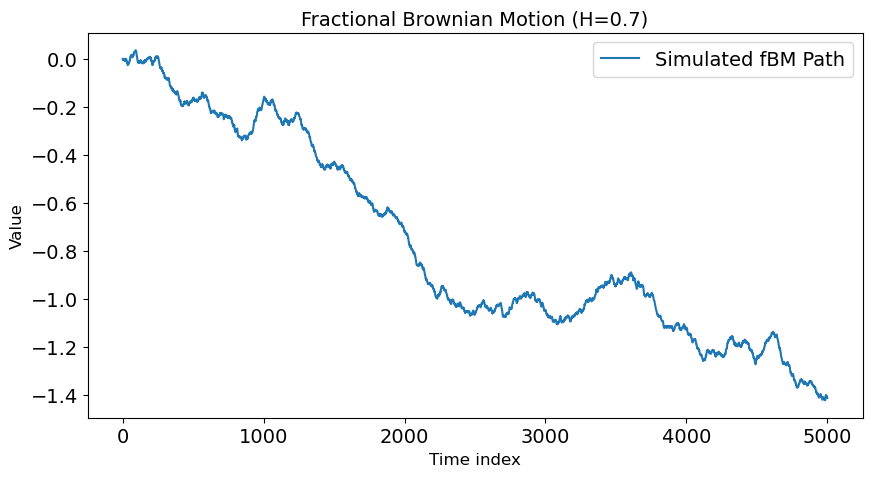

The actual Hurst exponent is: 0.7.
The estimated Hurst exponent (lag=200) is: 0.665.


In [3]:
## Rather than coding FBM myself, I simply import from: https://github.com/crflynn/stochastic
## To use: pip install stochastic
from stochastic.processes.continuous import FractionalBrownianMotion
import matplotlib.pyplot as plt

# Parameters
exponent = 0.7
n_points = 5000
lag = 200

# Generate one sample path of fBM
fbm_object = FractionalBrownianMotion(hurst=exponent, t=1)
fbm = fbm_object.sample(n_points)

# Compute estimated Hurst
hurst_exponent = var_of_diff_hurst(fbm, lag)

# Plot
plt.figure(figsize=(10,5))
plt.plot(fbm, label="Simulated fBM Path")
plt.title(f"Fractional Brownian Motion (H={exponent})", fontsize=14)
plt.xlabel("Time index", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend()

plt.show()

print(f"The actual Hurst exponent is: {exponent}.")
print(f"The estimated Hurst exponent (lag={lag}) is: {hurst_exponent:.3f}.")


The accuracy of the estimate will vary each time the code is run, but it is evident that the result is reasonable.

Before moving on, I use Monte Carlo simulation to estimate the optimal choice of lags.  I run two separate simulations to get a prediction of both the trend and variance of the error.  One simulation computes a new fBM every round, and therefore there is some variance in the average $H(lags)$.  The other simulation uses the same fBM for every lag, and thus provides a clearer estimate of the trend.

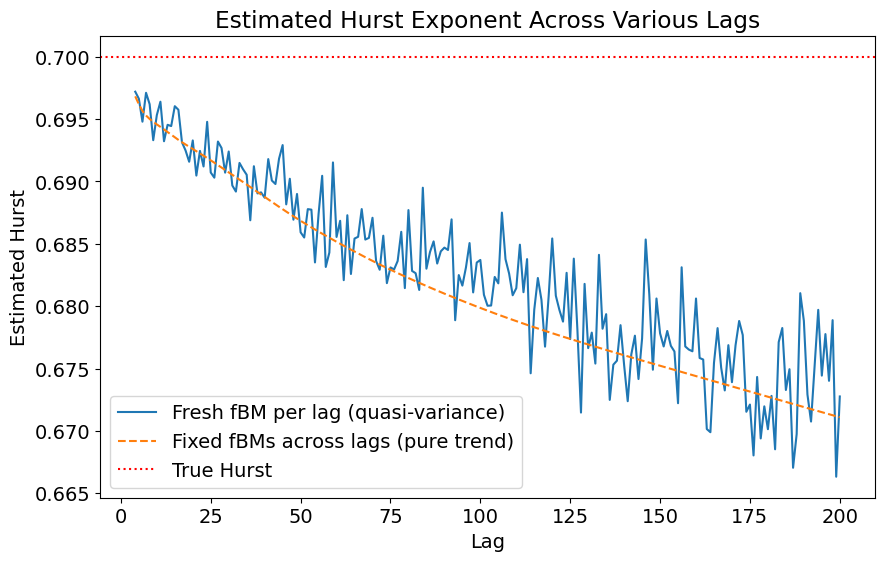

In [4]:
n_paths = 100
n_points = 5000
H_true = 0.7
lags = range(4, 201)

# Method 1: new fBM for each lag
results_new_paths = np.zeros(len(lags))
for idx, lag in enumerate(lags):
    cur = []
    for _ in range(n_paths):
        fbm_object = FractionalBrownianMotion(hurst=H_true, t=1)
        fbm = fbm_object.sample(n_points)
        cur.append(var_of_diff_hurst(fbm, lag))
    results_new_paths[idx] = np.mean(cur)


# Method 2: reuse same fBMs across lags
fbm_paths = []
for _ in range(n_paths):
    fbm_object = FractionalBrownianMotion(hurst=H_true, t=1)
    fbm_paths.append(fbm_object.sample(n_points))
fbm_paths = np.array(fbm_paths)

results_fixed_paths = np.zeros(len(lags))
for idx, lag in enumerate(lags):
    estimates = [var_of_diff_hurst(path, lag) for path in fbm_paths]
    results_fixed_paths[idx] = np.mean(estimates)


# Plot
plt.figure(figsize=(10,6))

plt.plot(lags, results_new_paths, label="Fresh fBM per lag (quasi-variance)")
plt.plot(lags, results_fixed_paths, label="Fixed fBMs across lags (pure trend)", linestyle="--")
plt.axhline(y=H_true, color="r", linestyle=":", linewidth=1.5, label="True Hurst")

plt.title("Estimated Hurst Exponent Across Various Lags")
plt.xlabel("Lag")
plt.ylabel("Estimated Hurst")
plt.legend()
plt.show()


In this case, it is evident that `Algorithm One` consistently underestimates the Hurst exponent, and that the degree of error worsens as the number of lags increases.  It also seems to be the case that the variance of the estimate is proportional to the number of lags considered.  These observations may be artifacts of the choice of $H=0.7$, and more robust testing is needed to determine if such behavior is consistent across all $H$.  The insight gleaned here, however, is very useful and is further prodded below.

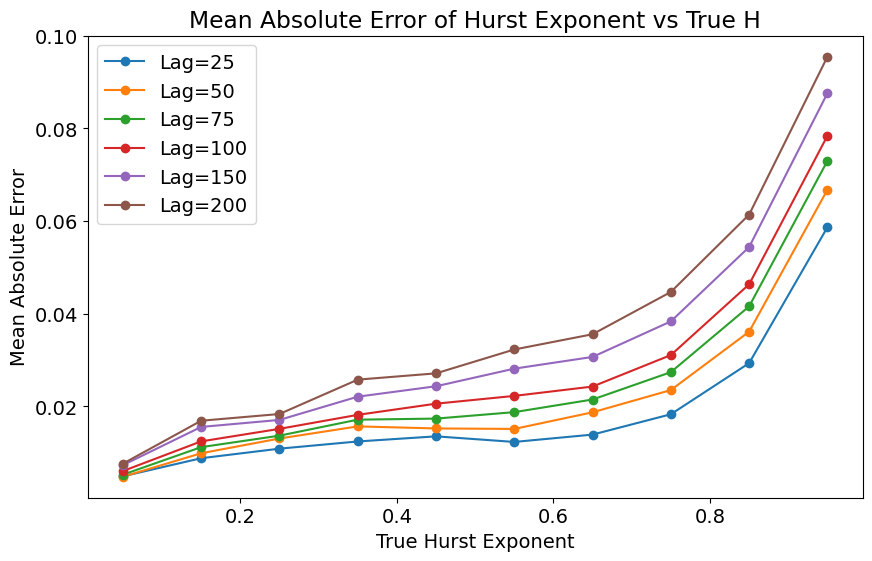

In [5]:
# Parameters
true_Hs = np.linspace(0.05, 0.95, 10)
n_paths = 100
n_points = 5000
lags_to_test = [25, 50, 75, 100, 150, 200]

results = {}

for lag in lags_to_test:
    results[lag] = []

# Generate a consistent set of fBMs and calculate Hurst exponent on these across various lags 
for H_true in true_Hs:
    fbm_paths = []
    for _ in range(n_paths):
        fbm_object = FractionalBrownianMotion(hurst=H_true, t=1)
        fbm_paths.append(fbm_object.sample(n_points))
    fbm_paths = np.array(fbm_paths)

    for lag in lags_to_test:
        errors = [abs(var_of_diff_hurst(path, lag) - H_true) for path in fbm_paths]
        results[lag].append(np.mean(errors))

# Plot
plt.figure(figsize=(10,6))

for lag, errors in results.items():
    plt.plot(true_Hs, errors, marker="o", label=f"Lag={lag}")

plt.title("Mean Absolute Error of Hurst Exponent vs True H")
plt.xlabel("True Hurst Exponent")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()


Here, the error using this algorithm worsens as $H$ increases across all lags.

WARNING: One might be tempted to draw a fallacious conclusion from above example. It seems that the smaller the set of lags considered, the better the estimate, as the $\text{Lag}=25$ curve consistently displays the minimum MAE.  Therefore, simply take as small of a lag as possible, and then the estimate will be best.  There are, however, instabilities that arise for small lags.  Furthermore, when the stochastic process under consideration is different, new behaviors emerge... 

To illustrate this, I first define a handful of functions for generating various timeseries.

Ornstein-Uhlenbeck Process (mean-reverting):

In [6]:
def OU_process(theta=10.7, mu=10.0, sigma=0.3, X0=10, T=10.0, dt=0.01):
    N=int(T/dt)
    X = np.zeros(N)
    X[0]=X0
    
    for t in range(1,N):
        dW = np.sqrt(dt)*np.random.normal(0,1)
        X[t] = X[t-1]+theta*(mu-X[t-1])*dt+sigma*dW
    return X

Brownian Motion (random walk):

In [7]:
def brownian_motion(mu=0.5, sigma=1.0, T = 10.0, dt=0.01):
    rng=np.random
    N = int(T/dt)
    Z = rng.normal(mu,sigma,N-1)
    interval = [0.0,1]
    t_axis = np.linspace(interval[0], interval[1], N-1)
    
    W = np.ones(N)
    for idx in range(N-1):
        W[idx+1] = W[idx] + np.sqrt(dt)*Z[idx]
    return W


Geometric Brownian Motion (random walk): 

In [8]:
def GBM_process(S0=1.0, mu=0.0, sigma=0.2, T=10.0, dt=0.01):

    N = int(T / dt)
    t = np.linspace(0, T, N)
    
    Z = np.random.normal(0, 1, N-1)
    
    log_returns = (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    log_S = np.log(S0) + np.cumsum(np.concatenate(([0], log_returns)))
    
    return np.exp(log_S)

With the code for the OU, BM, and GBM in place, it is now possible to further investigate the behavior of the Hurst estimator. Personally, I find the results for BM most interesting.

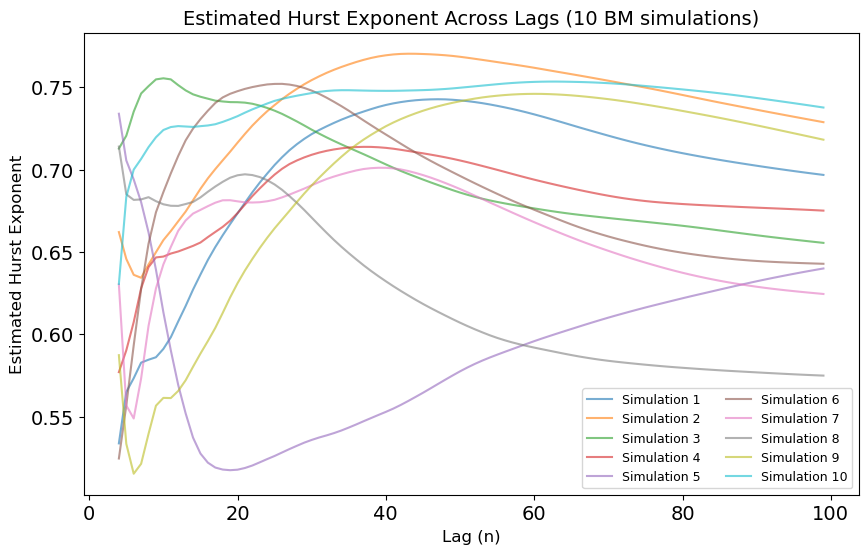

In [9]:
n = 200
plt.figure(figsize=(10,6))

for test in range(10):
    # CHOOSE A PROCESS:
    # -----------------
    #ts, name = OU_process(), "OU"
    ts, name = brownian_motion(), "BM"
    #ts, name = GBM_process(), "GBM"
    # -----------------

    result = []
    for lag in range(4, 100):
        result.append(var_of_diff_hurst(np.log(ts), lag))

    plt.plot(range(4, 100), result, alpha=0.6, label=f"Simulation {test+1}")

plt.title(f"Estimated Hurst Exponent Across Lags (10 {name} simulations)", fontsize=14)
plt.xlabel("Lag (n)", fontsize=12)
plt.ylabel("Estimated Hurst Exponent", fontsize=12)
plt.legend(loc="best", fontsize=9, ncol=2)
plt.show()


The behavior is erratic near zero lags, and as the lags increase sometimes the estimate deflates and other times it inflates. Such variable results for the same process, cast doubt that this approach will lead to a robust momentum indicator. 

An alternative to `Algorithm One` would be to use rescaled range analysis. The key difference is that the variance method estimates the Hurst exponent from the second-moment scaling of increments (i.e., how the variance of differences grows with lag), whereas rescaled range analysis is based on the scaling of the range of cumulative deviations (max–min) normalized by the standard deviation.

### Algorithm Two (Rescaled Range Analysis): 

The rescaled range method provides an alternative way to estimate the Hurst exponent. It is based on the idea that self-similar processes exhibit scaling behavior in the range of their cumulative fluctuations.

Given a time series $X_1, X_2, \dots, X_n$:

1. Compute the mean and standard deviation:
$$
\bar{X}_n = \frac{1}{n}\sum_{t=1}^n X_t, 
\qquad
S_n = \sqrt{\frac{1}{n}\sum_{t=1}^n (X_t - \bar{X}_n)^2}.
$$

2. Form the cumulative sum of deviations from the mean:
$$
Y_k = \sum_{t=1}^k (X_t - \bar{X}_n), 
\quad k = 1,2,\dots,n.
$$

3. Define the range of these cumulative deviations:
$$
R_n = \max_{1 \leq k \leq n} Y_k - \min_{1 \leq k \leq n} Y_k.
$$

4. Normalize (rescale) this range by the standard deviation:
$$
\frac{R_n}{S_n}.
$$

For self-similar processes, the expected rescaled range scales with block size $n$ as:
$$
\mathbb{E}\!\left[\frac{R_n}{S_n}\right]
$$

Therefore, $H$ can be estimated by regressing in log-space:
$$
\log \left(\frac{R_n}{S_n}\right) = \log C + H \log n.
$$


### Code for Rescaled Range Analysis:

There are lots of design choices that can be made when implementing the rescaled range method.  One of the main concerns is how to choose the set $\{n_i\}_{i=1}^k$ to use for calculating $\log \left(\frac{R_n}{S_n}\right) = \log C + H \log n.$

Common practice is to (in the convenenient case that the length of the time series is a power of two) cut the data in half, then into quarters, then eigths, etc. and use these as $\{n_i\}_{i=1}^k$.  In order to use this method, it is necessary to truncate the incoming time series.  My implementation below drops from the head (i.e the oldest data), as recent data is more important.

In [10]:
import statsmodels.api as sm
import math

def rescaled_range_hurst(timeseries):
    """
    Estimate the Hurst Exponent using the Rescale Range method
    
    Parameters
    ----------
    timeseries : array-like  //  Time series for which the Hurst Exponent will be calculated
    
    Returns
    -------
    H: float  // Estimated Hurst exponent
    """
    
    # Trim series to nearest power of 2 length
    m = len(timeseries)
    p2_length = 2 ** int(math.log2(m))
    drop_count = m - p2_length
    trimmed_ts = timeseries[drop_count:]
    
    # Initialize variables for estimation
    power_slice = 2
    n_vals = []
    rescaled_range_per_n = []
    N = len(trimmed_ts)

    # Loop through progressively larger chunk sizes
    while N // power_slice >= 50:
        chunks = rrh_chunks(N, power_slice)
        rr_per_chunk = []
        # Calculate R/S ratio for each chunk
        for idx in range(len(chunks)-1):
            X = trimmed_ts[chunks[idx]:chunks[idx+1]]
            mean = np.mean(X)
            mean_adjusted = X - mean
            cum_dev = np.cumsum(mean_adjusted)
            r = max(cum_dev) - min(cum_dev)
            s = np.std(mean_adjusted, ddof=1)
            if s>0:
                rr_per_chunk.append(r/s)
            
        if len(rr_per_chunk)>0:
            avg_rr = np.mean(rr_per_chunk)
            rescaled_range_per_n.append(avg_rr)
            n_vals.append(N // power_slice)
        
        power_slice*=2

    # Perform linear regression in log-log space
    X = np.log(n_vals)
    X = sm.add_constant(X)
    Y = np.log(rescaled_range_per_n)
        
    log_line = sm.OLS(Y,X).fit()
    H = log_line.params[1]
    return H

def rrh_chunks(length, number):
    # Helper method to make the chunks for analysis
    chunk_size = length // number
    result = []
    for i in range(number):
        result.append(i*chunk_size)
    result.append(length)
    return result

### Algorithm Two Performance Investigation

In [11]:
exponent = 0.7
n_points = 5000
fbm_object = FractionalBrownianMotion(hurst=exponent, t=1)
fbm = fbm_object.sample(n_points)
h = rescaled_range_hurst(fbm)
print(f"True Hurst exponent: {exponent}.")
print(f"Estimated Hurst exponent: {h}.")


True Hurst exponent: 0.7.
Estimated Hurst exponent: 1.0172330641481737.


What went wrong? As it turns out, R/S analysis requires increments!  (Or more precisely, some type of mean removal).  In particular, R/S analysis examines how the range of cumulative deviations from the mean scales with time. Raw prices violate this assumption, which leads to spurious results and overestimated Hurst exponents.  Therefore, we re-estimate the Hurst exponent using the differenced series.


In [12]:
print(f"Estimated Hurst of diff fBM: {rescaled_range_hurst(np.diff(fbm))}")


Estimated Hurst of diff fBM: 0.731967585914667


One issue for the purposes of stock prediction, however, is that the above method is data hungry. In particular, 
it uses powers of two for chunk lengths, meaning that only $\log_2(n)$ points are used in the regression.  This means that the length of the series needs to be large for the estimate to be good.  Ideally, I would like to be able to feed a Hurst estimator much less data while still getting a reasonable output. This would in theory enable the estimator to react quicker to new market trends.  Thus, it is necessary to find a better implementation.

After much experimentation, I settled on the below approach.  There are many subtleties involved in making the algorithm appropriate for short time frames.  While it seems reasonable from the outset to simply take all values of $n$ up until `len(timeseries) // 2` or maybe even up to `len(timeseries)` itself, this causes a bias in the log regression, as the data will become poorly distributed along the independent axis.  Making $n$ too small destroys reliability of the estimator, as does not taking enough chunks.  

The approach below uses roughly log spacing of the points (which avoids errors induced by unequal spacing and sidesteps the need to fix this via weighted linear regression), and an aggressive overlap, which does introduce correlation of errors and noise, but this far outweights the error induced through limited data.

In [13]:
import numpy as np
import statsmodels.api as sm

def rescaled_range_hurst_short(timeseries, min_size=5, max_scales=8, overlap=0.9):
    """
    Estimate the Hurst Exponent using the Rescale Range method, optimized for short time series
    
    Parameters
    ----------
    timeseries : array-like  //  Time series for which the Hurst Exponent will be calculated
    min_size : int  // Smallest window length used
    max_scales : int  //  Target number of distinct window sizes
    overlap : float  //  Fractional overlap between consecutive windows of the same size
    
    Returns
    -------
    H: float  // Estimated Hurst exponent
    """
    N = len(timeseries)
    
    # Create window sizes: even log-spacing to avoid bias
    max_size = max(N // 2, min_size + 1)
    
    if max_size <= min_size:
        sizes = [min_size]
    else:
        # Even spacing in log-space
        log_sizes = np.linspace(np.log(min_size), np.log(max_size), max_scales)
        sizes = np.unique(np.round(np.exp(log_sizes)).astype(int))
        sizes = [s for s in sizes if min_size <= s <= max_size]
    
    n_vals, rs_vals = [], []
    
    for n in sizes:
        rs_list = []
        # Heavy overlap: step = (1 - overlap) * window_size
        step = max(1, int(n * (1 - overlap)))
        
        for start in range(0, N - n + 1, step):
            chunk = timeseries[start:start + n]
            
            # R/S calculation
            mean_adj = chunk - np.mean(chunk)
            cumsum = np.cumsum(mean_adj)
            R = np.max(cumsum) - np.min(cumsum)
            S = np.std(chunk, ddof=1)
            
            if S > 0:
                rs_list.append(R / S)
        
        if rs_list:
            n_vals.append(n)
            rs_vals.append(np.mean(rs_list))
    
    # Log-log regression
    if len(n_vals) < 2:  # Relaxed requirement for very short series
        raise ValueError(f"Need at least 2 scales, got {len(n_vals)} (series length: {N})")
    
    X = sm.add_constant(np.log(n_vals))
    Y = np.log(rs_vals)
    return sm.OLS(Y, X).fit().params[1]


Now it would be nice to see how well the estimator actually does as a function both of the particular Hurst exponent as well as the length of the inputted time series.

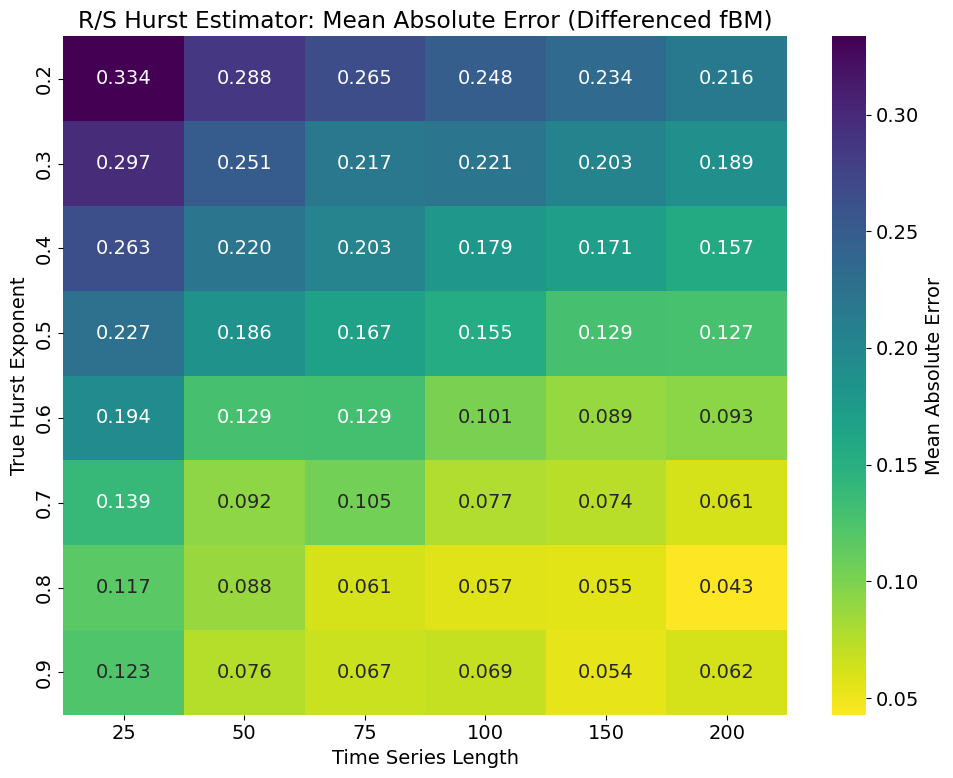

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_hurst_errors(FractionalBrownianMotion, rescaled_range_hurst_short, n_trials=100):
    """
    Analysis of R/S Hurst estimator errors 
    
    Parameters
    ----------
    FractionalBrownianMotion : Class  //  Generates fBM of a given Hurst exponent
    rescaled_range_hurst_short : function  //  Generates an estimate of the Hurst exponent
    n_trials : int  //  Number of Monte Carlo trials per (length, hurst) combination
    
    Returns
    -------
    errors: ndarray  // Matrix containing the errors from the Monte Carlo simulations for (length, hurst)
    """
    
    # Test parameters
    series_lengths = [25, 50, 75, 100, 150, 200]
    true_hursts = np.arange(0.2, 1.0, 0.1)
    
    # Results matrix: rows=true_hursts, cols=series_lengths
    errors = np.zeros((len(true_hursts), len(series_lengths)))
    
    for i, true_h in enumerate(true_hursts):
        for j, length in enumerate(series_lengths):
            trial_errors = []
            
            for trial in range(n_trials):
                fbm_object = FractionalBrownianMotion(hurst=true_h, t=1)
                fbm = fbm_object.sample(length + 1)  # +1 because we diff
                test = np.diff(fbm)
                
                # Estimate Hurst 
                estimated_h = rescaled_range_hurst_short(test)
                trial_errors.append(abs(estimated_h - true_h))
        
            errors[i, j] = np.mean(trial_errors)
    
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        errors,
        xticklabels=series_lengths,
        yticklabels=[f"{h:.1f}" for h in true_hursts],
        annot=True,
        fmt='.3f',
        cmap='viridis_r',
        cbar_kws={'label': 'Mean Absolute Error'}
    )
    plt.title('R/S Hurst Estimator: Mean Absolute Error (Differenced fBM)')
    plt.xlabel('Time Series Length')
    plt.ylabel('True Hurst Exponent')
    plt.tight_layout()
    plt.show()
    
    return errors

errors = analyze_hurst_errors(FractionalBrownianMotion, rescaled_range_hurst_short)

Interestingly, it seems this method displays the opposite problem of `Algorithm One`!  Here the errors are greatest for low values of Hurst.

The biggest conclusion that we can draw from this heatmap, however, is that this is a totally unsuitable estimator for the purposes of momentum detection in the stock market.  Such magnitudes of error are completely unacceptable.  I should note that of course the testing performed is not all encompasing.  For example, there may be underlying distributions for which this estimator performs exceedingly well.  In the interest of time, however, I feel that given the above results it is better to move on and try to find a different approach.

Having now found some papers on algorithms that are supposedly well-suited for short length series (Generalized Hurst Exponent, Local Whittle, Kolmogorov-Smirnov, and Hurst-Kolmogorov), these would be natural methods to examine next.  Yet, I also read that the variance of differences methods is one of the best approaches for short series, which I have already implemented as `Algorithm One`.  As such, I could simply proceed to building a more general momentum detection model, and only then attempting to optimize the Hurst estimation. 

Additionally, implicit in my hunt for a method that is both robust and can handle short time series is the assumption that such methods will necessarily do better at detecting regime changes.  This assumption is not necessarily true, and can be prodded on actual stock data.

